In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import psutil


class VAE(nn.Module):
    def __init__(self, latent_dim=200):
        super(VAE, self).__init__()

        # Encoder: 4 Conv2d layers with stride=2, kernel=4, padding=1
        # Input: (3, 64, 64) -> (32, 32, 32) -> (64, 16, 16) -> (128, 8, 8) -> (256, 4, 4)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),    # 0
            nn.ReLU(),                                                # 1
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),   # 2
            nn.ReLU(),                                                # 3
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 4
            nn.ReLU(),                                                # 5
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # 6
            nn.ReLU(),                                                # 7
        )

        # 256 * 4 * 4 = 4096
        self.fc_mu = nn.Linear(4096, latent_dim)
        self.fc_logvar = nn.Linear(4096, latent_dim)

        # Decoder input
        self.decoder_input = nn.Linear(latent_dim, 4096)

        # Decoder: 4 ConvTranspose2d layers
        # (256, 4, 4) -> (128, 8, 8) -> (64, 16, 16) -> (32, 32, 32) -> (3, 64, 64)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 0
            nn.ReLU(),                                                          # 1
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 2
            nn.ReLU(),                                                          # 3
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # 4
            nn.ReLU(),                                                          # 5
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),     # 6
            nn.Sigmoid(),                                                       # 7
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten to (batch, 4096)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(x.size(0), 256, 4, 4)  # Reshape to (batch, 256, 4, 4)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
from copy import deepcopy
from torch.optim import AdamW

# --- Classe Principale STDM ---

class StdmVAE:
    def __init__(self, model, device="cuda"):
        self.device = device
        self.model = model

        # Configuration par defaut
        self.config = {
            "layer_name": "decoder.6.weight",  # Couche cible
            "watermark_len": 16,
            "lr": 1e-4,
            "lambda_wat": 1.0,
            "epochs": 10,
            "alpha": 10.0,  # Parametre STDM
            "beta": 0.1,
            "beta_kl":1.0# Parametre STDM
        }

        self.saved_keys = {}

    def _get_target_weights(self, model):
        """Recupere le tenseur des poids de la couche cible."""
        for name, param in model.named_parameters():
            if name == self.config["layer_name"]:
                return param
        raise ValueError(f"Parametre {self.config['layer_name']} introuvable.")

    @staticmethod
    def _theta(x, alpha_, beta_):
        """Fonction theta de STDM."""
        numerator = torch.exp(alpha_ * torch.sin(torch.tensor(beta_) * x))
        denominator = 1 + torch.exp(alpha_ * torch.sin(torch.tensor(beta_) * x))
        return numerator / denominator

    def embed(self, dataloader):
        """
        Incorpore la marque STDM (Spread Transform Dither Modulation) pendant le finetuning.
        """
        print(f"--- Demarrage Embedding STDM ({self.config['layer_name']}) ---")

        watermarked_model = self.model
        watermarked_model.train()

        # 1. Generation des Cles (Matrice A normalisee L2 et Watermark binaire)
        target_weights = self._get_target_weights(watermarked_model)
        print(target_weights.shape)
        with torch.no_grad():
            w_flat_dim = torch.flatten(target_weights.mean(dim=0)).shape[0]

        print(f"Dimension vecteur poids : {w_flat_dim} | Watermark : {self.config['watermark_len']} bits")

        # Matrice A normalisee L2 sur les colonnes (specifique STDM)
        matrix_a = torch.randn(w_flat_dim, self.config["watermark_len"]).to(self.device)
        matrix_a = F.normalize(matrix_a, p=2, dim=0)

        watermark_target = torch.randint(0, 2, (self.config["watermark_len"],)).float().to(self.device)

        # 2. Optimiseur
        optimizer = torch.optim.AdamW(watermarked_model.parameters(), lr=self.config["lr"])
        mse_loss = nn.MSELoss()
        bce_loss = nn.BCELoss()

        alpha_ = self.config["alpha"]
        beta_ = self.config["beta"]

        # 3. Boucle d'entrainement
        for epoch in range(self.config["epochs"]):
            pbar = tqdm(dataloader)
            for clean_images, _ in pbar:
                clean_images = clean_images.to(self.device)
                optimizer.zero_grad()

                recon, mu, logvar = watermarked_model(clean_images)

                # Reconstruction loss
                l_recon = F.mse_loss(recon, clean_images)

                # KL divergence
                l_kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

                # VAE total task loss
                l_main = l_recon + self.config["beta_kl"] * l_kl


                # C. Watermark Loss (STDM avec fonction theta)
                current_weights = self._get_target_weights(watermarked_model)
                w_flat = torch.flatten(current_weights.mean(dim=0))

                # Projection avec fonction theta (specifique STDM)
                pred_wm_prob = self._theta(w_flat @ matrix_a, alpha_, beta_)
                l_wat = bce_loss(pred_wm_prob, watermark_target)

                # Loss Totale
                l_total = l_main + self.config["lambda_wat"] * l_wat

                l_total.backward()
                optimizer.step()

                # Metrics
                ber = self._compute_ber(pred_wm_prob, watermark_target)
                pbar.set_description(f"Epoch {epoch+1} | L_Main: {l_main:.3f} | L_Wat: {l_wat:.3f} | BER: {ber:.2f}")

            #     if ber == 0.0 and l_wat.item() < 0.01:
            #         print("Convergence atteinte !")
            #         break
            # if ber == 0.0:
            #     break

        # Sauvegarde des cles
        self.saved_keys = {
            "matrix_a": matrix_a,
            "watermark_target": watermark_target,
            "watermarked_model": watermarked_model,
            "alpha": alpha_,
            "beta": beta_,
        }
        torch.save(self.saved_keys, "Stdm_VAE_model_checkpoint.pt")
        return watermarked_model

    def extract(self, model=None):
        """
        Extrait la marque d'un modele suspect (lecture des poids).
        """
        if model is None:
            model = self.saved_keys["watermarked_model"]

        matrix_a = self.saved_keys["matrix_a"]
        watermark_target = self.saved_keys["watermark_target"]
        alpha_ = self.saved_keys["alpha"]
        beta_ = self.saved_keys["beta"]

        # 1. Recuperation des poids
        try:
            target_weights = self._get_target_weights(model)
        except ValueError:
            print("Couche cible introuvable dans le modele suspect.")
            return 1.0, None  # BER max

        # 2. Projection avec theta
        with torch.no_grad():
            w_flat = torch.flatten(target_weights.mean(dim=0))
            pred_wm_prob = self._theta(w_flat @ matrix_a, alpha_, beta_)

            ber = self._compute_ber(pred_wm_prob, watermark_target)

        print(f"BER Extrait : {ber:.2f}")
        return ber, pred_wm_prob

    @staticmethod
    def _compute_ber(pred, target):
        return ((pred > 0.5).float() != target).float().mean().item()


/home/latim/PycharmProjects/WatDNN/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from datasets import load_dataset
from torch.utils.data import DataLoader
import torch
from torchvision import transforms

import os
import torch
import gc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load from Hugging Face (no Google Drive issues)
print("Loading dataset...")


from datasets import load_from_disk
hf_dataset = load_from_disk("celeba_local")
# os.makedirs("./celeba_images/all", exist_ok=True)
# for i, item in enumerate(hf_dataset):
#     item['image'].save(f"./celeba_images/all/{i:06d}.jpg")
# del hf_dataset


class CelebAWrapper(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        if self.transform:
            image = self.transform(image)
        return image, 0

dataset = CelebAWrapper(hf_dataset, transform)
# del hf_dataset
# gc.collect()
# dataset = datasets.ImageFolder("./celeba_images", transform=transform)
print("Dataset loaded!")

dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
print("loader loaded!")


Loading dataset...
Dataset loaded!
loader loaded!


In [4]:
latent_dim = 200

# Initialize the model
model = VAE(latent_dim=latent_dim)

# Load the trained weights
model_path = "./vae_celeba_latent_200_epochs_10_batch_64_subset_80000.pth"
model.load_state_dict(torch.load(model_path))
model.to(device)
# 2. Embedding STDM
stdm_defense = StdmVAE(model, device=device)
watermarked_model = stdm_defense.embed(dataloader)

--- Demarrage Embedding STDM (decoder.6.weight) ---
torch.Size([32, 3, 4, 4])
Dimension vecteur poids : 48 | Watermark : 16 bits


Epoch 1 | L_Main: 0.297 | L_Wat: 0.553 | BER: 0.06: 100%|██████████| 3166/3166 [01:25<00:00, 37.11it/s]
Epoch 2 | L_Main: 0.294 | L_Wat: 0.419 | BER: 0.00: 100%|██████████| 3166/3166 [01:23<00:00, 38.00it/s]
Epoch 3 | L_Main: 0.291 | L_Wat: 0.316 | BER: 0.00: 100%|██████████| 3166/3166 [01:23<00:00, 37.98it/s]
Epoch 4 | L_Main: 0.309 | L_Wat: 0.240 | BER: 0.00: 100%|██████████| 3166/3166 [01:22<00:00, 38.37it/s]
Epoch 5 | L_Main: 0.299 | L_Wat: 0.181 | BER: 0.00: 100%|██████████| 3166/3166 [01:22<00:00, 38.14it/s]
Epoch 6 | L_Main: 0.306 | L_Wat: 0.137 | BER: 0.00: 100%|██████████| 3166/3166 [01:22<00:00, 38.33it/s]
Epoch 7 | L_Main: 0.315 | L_Wat: 0.103 | BER: 0.00: 100%|██████████| 3166/3166 [01:23<00:00, 38.01it/s]
Epoch 8 | L_Main: 0.312 | L_Wat: 0.078 | BER: 0.00: 100%|██████████| 3166/3166 [01:22<00:00, 38.58it/s]
Epoch 9 | L_Main: 0.300 | L_Wat: 0.059 | BER: 0.00: 100%|██████████| 3166/3166 [01:22<00:00, 38.33it/s]
Epoch 10 | L_Main: 0.326 | L_Wat: 0.045 | BER: 0.00: 100%|██████

In [5]:
# 3. Extraction (Test immediat)
ber, _ = stdm_defense.extract(watermarked_model)
print(f"\nResultat final - BER: {ber:.2f}")

BER Extrait : 0.00

Resultat final - BER: 0.00


In [6]:
# --- Fonction de Distillation (Attaque) ---

def run_distillation_attack_stdm(stdm_obj, dataloader, epochs=5, lr=1e-4):
    """
    Tente de transferer la fonctionnalite du modele STDM vers un modele vierge.
    Verifie si la marque (basee sur les poids) survit.
    """
    device = stdm_obj.device
    checkpoint = torch.load("Stdm_VAE_model_checkpoint.pt", weights_only=False)

    # 1. Teacher (Gele)
    teacher = checkpoint["watermarked_model"]
    teacher.eval()
    for p in teacher.parameters():
        p.requires_grad = False

    # 2. Student (Vierge - Meme architecture)
    print("\n--- Initialisation du Student ---")
    student=VAE(latent_dim=latent_dim)
    student.load_state_dict(torch.load(model_path))
    student.to(device)
    student.train()

    teacher_ber, _ = stdm_obj.extract(teacher)
    student_ber, _ = stdm_obj.extract(student)
    # Sanity Checks
    print(f"[Check] BER Teacher: {teacher_ber:.2f}")
    print(f"[Check] BER Student (Avant): {student_ber:.2f}")

    optimizer = AdamW(student.parameters(), lr=lr)

    history = {"loss": [], "ber": []}

    print(f"\n--- Distillation STDM ({epochs} epochs) ---")
    a=0

    for epoch in range(epochs):
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}")
        running_loss = 0.0

        for clean_images, _ in pbar:
            clean_images = clean_images.to(device)

            # B. Distillation (Output Matching)
            with torch.no_grad():
                target_pred,_,_ = teacher(clean_images)

            student_pred,_,_ = student(clean_images)

            loss = F.mse_loss(student_pred, target_pred)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix(Loss=loss.item())

        # C. Verification : Est-ce que les poids se sont alignes sur STDM ?
        current_ber, pred_wm_prob = stdm_obj.extract(student)
        history["ber"].append(current_ber)
        history["loss"].append(running_loss / len(dataloader))

        err_wat = nn.BCELoss()(pred_wm_prob, checkpoint["watermark_target"]) if pred_wm_prob is not None else float('nan')
        print(f"Fin Epoch {epoch+1} | Loss: {history['loss'][-1]:.4f} | BER Student: {current_ber:.2f} | err_wat: {err_wat:.4f}")
        if current_ber==0.0 and a>=1:
            print("✅ Marque récupérée avec succès par distillation !")
            break
        elif current_ber==0.0 and a<1 :
            a+=1
        else:
            a=0

    return student, history


In [7]:
# 4. Attaque par Distillation
student_res, stats = run_distillation_attack_stdm(stdm_defense, dataloader, epochs=100)


--- Initialisation du Student ---
BER Extrait : 0.00
BER Extrait : 0.56
[Check] BER Teacher: 0.00
[Check] BER Student (Avant): 0.56

--- Distillation STDM (100 epochs) ---


Epoch 1: 100%|██████████| 3166/3166 [01:22<00:00, 38.26it/s, Loss=0.00653]


BER Extrait : 0.19
Fin Epoch 1 | Loss: 0.0085 | BER Student: 0.19 | err_wat: 0.6911


Epoch 2: 100%|██████████| 3166/3166 [01:23<00:00, 38.12it/s, Loss=0.00706]


BER Extrait : 0.12
Fin Epoch 2 | Loss: 0.0073 | BER Student: 0.12 | err_wat: 0.6908


Epoch 3: 100%|██████████| 3166/3166 [01:25<00:00, 36.84it/s, Loss=0.00624]


BER Extrait : 0.12
Fin Epoch 3 | Loss: 0.0072 | BER Student: 0.12 | err_wat: 0.6904


Epoch 4: 100%|██████████| 3166/3166 [01:44<00:00, 30.21it/s, Loss=0.00965]


BER Extrait : 0.12
Fin Epoch 4 | Loss: 0.0072 | BER Student: 0.12 | err_wat: 0.6902


Epoch 5: 100%|██████████| 3166/3166 [01:56<00:00, 27.20it/s, Loss=0.0095] 


BER Extrait : 0.12
Fin Epoch 5 | Loss: 0.0072 | BER Student: 0.12 | err_wat: 0.6901


Epoch 6: 100%|██████████| 3166/3166 [01:44<00:00, 30.31it/s, Loss=0.00607]


BER Extrait : 0.12
Fin Epoch 6 | Loss: 0.0072 | BER Student: 0.12 | err_wat: 0.6899


Epoch 7: 100%|██████████| 3166/3166 [01:43<00:00, 30.54it/s, Loss=0.00592]


BER Extrait : 0.12
Fin Epoch 7 | Loss: 0.0071 | BER Student: 0.12 | err_wat: 0.6898


Epoch 8: 100%|██████████| 3166/3166 [01:42<00:00, 30.75it/s, Loss=0.00735]


BER Extrait : 0.12
Fin Epoch 8 | Loss: 0.0071 | BER Student: 0.12 | err_wat: 0.6897


Epoch 9: 100%|██████████| 3166/3166 [01:38<00:00, 32.02it/s, Loss=0.006]  


BER Extrait : 0.12
Fin Epoch 9 | Loss: 0.0071 | BER Student: 0.12 | err_wat: 0.6896


Epoch 10: 100%|██████████| 3166/3166 [02:08<00:00, 24.57it/s, Loss=0.00623]


BER Extrait : 0.12
Fin Epoch 10 | Loss: 0.0071 | BER Student: 0.12 | err_wat: 0.6895


Epoch 11: 100%|██████████| 3166/3166 [02:40<00:00, 19.73it/s, Loss=0.00823]


BER Extrait : 0.12
Fin Epoch 11 | Loss: 0.0071 | BER Student: 0.12 | err_wat: 0.6894


Epoch 12: 100%|██████████| 3166/3166 [02:03<00:00, 25.60it/s, Loss=0.00612]


BER Extrait : 0.12
Fin Epoch 12 | Loss: 0.0071 | BER Student: 0.12 | err_wat: 0.6893


Epoch 13: 100%|██████████| 3166/3166 [01:27<00:00, 36.37it/s, Loss=0.00693]


BER Extrait : 0.12
Fin Epoch 13 | Loss: 0.0071 | BER Student: 0.12 | err_wat: 0.6892


Epoch 14: 100%|██████████| 3166/3166 [01:24<00:00, 37.45it/s, Loss=0.00682]


BER Extrait : 0.12
Fin Epoch 14 | Loss: 0.0071 | BER Student: 0.12 | err_wat: 0.6892


Epoch 15: 100%|██████████| 3166/3166 [01:24<00:00, 37.36it/s, Loss=0.00567]


BER Extrait : 0.12
Fin Epoch 15 | Loss: 0.0071 | BER Student: 0.12 | err_wat: 0.6892


Epoch 16: 100%|██████████| 3166/3166 [01:23<00:00, 38.14it/s, Loss=0.00738]


BER Extrait : 0.12
Fin Epoch 16 | Loss: 0.0071 | BER Student: 0.12 | err_wat: 0.6891


Epoch 17: 100%|██████████| 3166/3166 [01:24<00:00, 37.29it/s, Loss=0.00858]


BER Extrait : 0.12
Fin Epoch 17 | Loss: 0.0071 | BER Student: 0.12 | err_wat: 0.6891


Epoch 18: 100%|██████████| 3166/3166 [01:23<00:00, 37.76it/s, Loss=0.00686]


BER Extrait : 0.12
Fin Epoch 18 | Loss: 0.0071 | BER Student: 0.12 | err_wat: 0.6890


Epoch 19: 100%|██████████| 3166/3166 [01:23<00:00, 37.90it/s, Loss=0.00651]


BER Extrait : 0.12
Fin Epoch 19 | Loss: 0.0071 | BER Student: 0.12 | err_wat: 0.6889


Epoch 20: 100%|██████████| 3166/3166 [01:23<00:00, 37.98it/s, Loss=0.00567]


BER Extrait : 0.06
Fin Epoch 20 | Loss: 0.0071 | BER Student: 0.06 | err_wat: 0.6889


Epoch 21: 100%|██████████| 3166/3166 [01:24<00:00, 37.37it/s, Loss=0.00948]


BER Extrait : 0.06
Fin Epoch 21 | Loss: 0.0071 | BER Student: 0.06 | err_wat: 0.6888


Epoch 22: 100%|██████████| 3166/3166 [01:23<00:00, 37.80it/s, Loss=0.00518]


BER Extrait : 0.00
Fin Epoch 22 | Loss: 0.0071 | BER Student: 0.00 | err_wat: 0.6887


Epoch 23: 100%|██████████| 3166/3166 [01:24<00:00, 37.25it/s, Loss=0.00582]

BER Extrait : 0.00
Fin Epoch 23 | Loss: 0.0071 | BER Student: 0.00 | err_wat: 0.6887
✅ Marque récupérée avec succès par distillation !


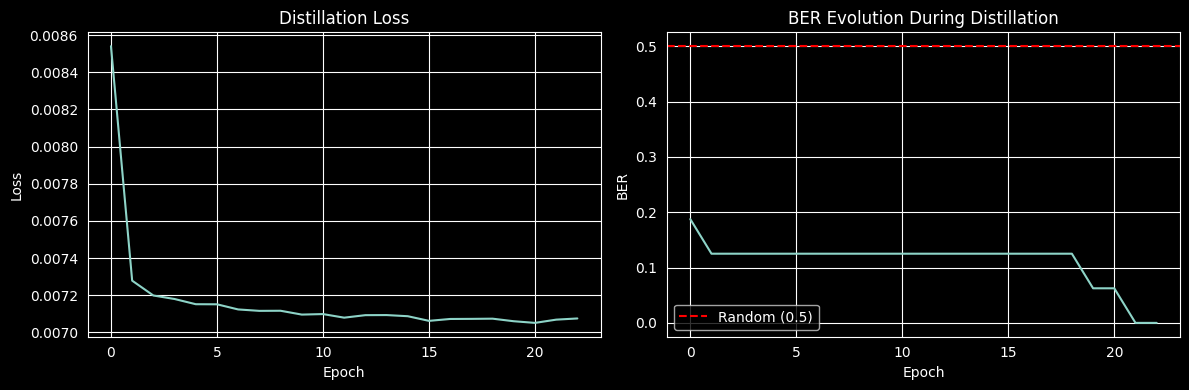

In [8]:
# 5. Visualisation des resultats
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(stats["loss"])
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Distillation Loss")

ax2.plot(stats["ber"])
ax2.axhline(y=0.5, color='r', linestyle='--', label='Random (0.5)')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("BER")
ax2.set_title("BER Evolution During Distillation")
ax2.legend()

plt.tight_layout()
plt.show()